<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/coursera-gan-specialization/blob/main/deBlurGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.2 MB/s eta 0:00:00


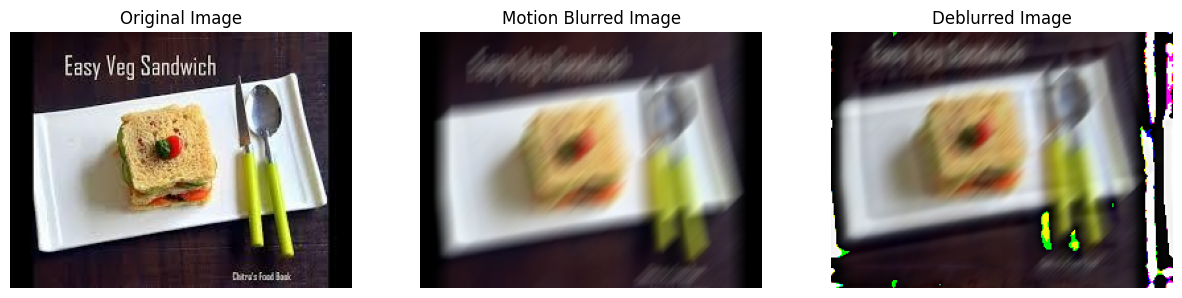

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from numpy.fft import fft2, ifft2, fftshift

def motion_blur_kernel(size, angle):
    """Generate a motion blur kernel."""
    kernel = np.zeros((size, size))
    kernel[int((size - 1) / 2), :] = np.ones(size)
    M = cv2.getRotationMatrix2D((size / 2 - 0.5, size / 2 - 0.5), angle, 1)
    kernel = cv2.warpAffine(kernel, M, (size, size))
    return kernel / kernel.sum()

def apply_motion_blur(image, size=15, angle=0):
    """Apply motion blur to an RGB image."""
    kernel = motion_blur_kernel(size, angle)
    blurred_image = np.zeros_like(image)
    for i in range(3):  # Apply blur to each channel
        blurred_image[:, :, i] = convolve(image[:, :, i], kernel, mode='reflect')
    return blurred_image

def wiener_filter(blurred_img, kernel, K=0.05):
    """Apply the Wiener filter to deblur an image using an adjusted K value for better regularization."""
    deblurred_img = np.zeros_like(blurred_img)
    kernel_fft = fft2(kernel, s=blurred_img.shape[:2])
    dummy = np.zeros_like(kernel)
    dummy[0,0] = 1  # Delta function
    dummy_fft = fft2(dummy, s=blurred_img.shape[:2])
    for i in range(3):  # Apply Wiener filter to each channel
        blurred_fft = fft2(blurred_img[:, :, i])
        wiener_filter = np.conj(kernel_fft) / (np.abs(kernel_fft)**2 + K)
        deblurred_fft = wiener_filter * blurred_fft / dummy_fft
        deblurred_img[:, :, i] = np.fft.ifft2(deblurred_fft).real
    return deblurred_img

# Call this function with the new K parameter after blurring to see if there's an improvement.


def display_images(image_path):
    """Load the image, apply motion blur, deblur it, and display all side by side."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    blurred_image = apply_motion_blur(image, 20, 45)  # Modify size and angle for different effects
    kernel = motion_blur_kernel(20, 45)
    deblurred_image = wiener_filter(blurred_image, kernel, 0.1)

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred_image)
    plt.title('Motion Blurred Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(deblurred_image.clip(0, 255).astype(np.uint8))
    plt.title('Deblurred Image')
    plt.axis('off')

    plt.show()

# Usage
display_images("/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg")  # Change to the path of your image


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import restoration
from scipy.signal import convolve2d as conv2

def apply_motion_blur(image, size=15, angle=0):
    """Simulate motion blur on an image using a simple linear kernel."""
    kernel = np.zeros((1, size))
    kernel[0, :] = np.ones(size)
    kernel = cv2.getRotationMatrix2D((size / 2, 0), angle, 1)[0:2]
    blurred = cv2.warpAffine(kernel.reshape(1, -1), kernel, (size, 1)).reshape(size, size)
    blurred /= blurred.sum()
    return conv2(image, blurred, 'same')

def tv_regularized_deconvolution(blurred_img, kernel, weight=0.1, eps=1e-5):
    """Apply total variation regularization deconvolution."""
    deconvolved, _ = restoration.unsupervised_wiener(blurred_img, kernel, clip=False, reg=weight, is_real=False, eps=eps)
    return deconvolved

# Load the image
image_path = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Apply synthetic motion blur
blurred_image = apply_motion_blur(image, size=21, angle=-30)

# Create a corresponding PSF
kernel = motion_blur_kernel(21, -30)

# Deconvolve using TV regularization
deconvolved_image = tv_regularized_deconvolution(blurred_image, kernel, weight=0.1)

# Display the results
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.subplot(133)
plt.imshow(deconvolved_image, cmap='gray')
plt.title('Deconvolved Image')
plt.axis('off')
plt.show()


ValueError: cannot reshape array of size 21 into shape (21,21)

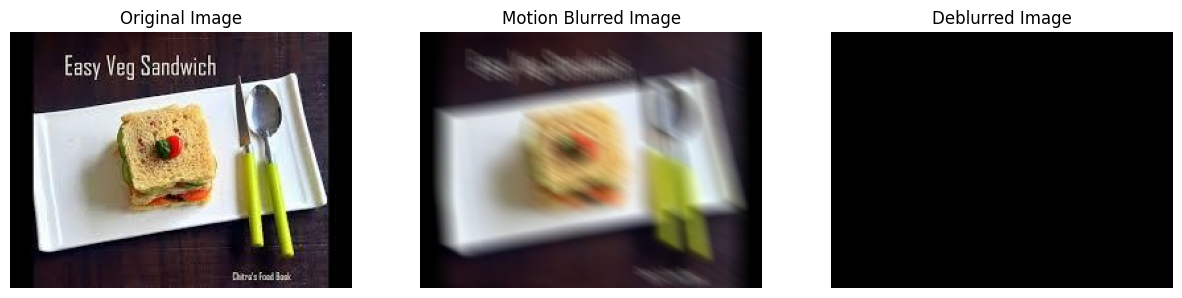

In [12]:
import numpy as np
import cv2
from scipy.signal import convolve2d as conv2
from skimage.restoration import richardson_lucy
import matplotlib.pyplot as plt

def motion_blur_kernel(size, angle):
    """Generate a motion blur kernel."""
    kernel = np.zeros((size, size))
    kernel[int(size / 2), :] = np.ones(size)
    M = cv2.getRotationMatrix2D((size / 2, size / 2), angle, 1)
    kernel = cv2.warpAffine(kernel, M, (size, size))
    kernel /= kernel.sum()
    return kernel

def apply_motion_blur(image, size=15, angle=0):
    """Apply motion blur to an image."""
    kernel = motion_blur_kernel(size, angle)
    blurred_image = np.zeros_like(image)
    for i in range(3):  # Apply blur to each channel
        blurred_image[:, :, i] = conv2(image[:, :, i], kernel, mode='same', boundary='wrap')
    return blurred_image

def richardson_lucy_deconvolution(blurred_img, kernel, iterations=30):
    """Apply Richardson-Lucy deconvolution to deblur an image."""
    deblurred_img = np.zeros_like(blurred_img)
    for i in range(3):  # Deconvolve each channel
        deblurred_img[:, :, i] = richardson_lucy(blurred_img[:, :, i], kernel, iterations)
    return deblurred_img

def display_images(image, blurred_image, deblurred_image):
    """Display original, blurred, and deblurred images."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
    plt.title('Motion Blurred Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
    plt.title('Deblurred Image')
    plt.axis('off')

    plt.show()

# Example usage
image_path =  "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg"
image = cv2.imread(image_path)
blurred_image = apply_motion_blur(image, 21, -30)  # Adjust kernel size and angle as needed
kernel = motion_blur_kernel(21, -30)
deblurred_image = richardson_lucy_deconvolution(blurred_image, kernel, 30)  # Adjust iterations as needed
display_images(image, blurred_image, deblurred_image)


In [16]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from DeblurGAN.model.networks import Generator

def load_pretrained_model():
    # Load the pre-trained generator
    net = Generator()
    state_dict = torch.load('/content/DeblurGAN/checkpoints/experiment_name/latest_net_G.pth')  # Load the weights
    net.load_state_dict(state_dict['generator'])
    return net

def deblur_image(image_path, model):
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Pre-process the image
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalize(to_tensor(img)).unsqueeze(0)  # Add batch dimension

    # Deblur the image
    model.eval()
    with torch.no_grad():
        deblurred_tensor = model(img)

    # Convert back to image
    to_pil = transforms.ToPILImage()
    deblurred_image = to_pil(deblurred_tensor.squeeze(0))
    return deblurred_image

# Example usage
model = load_pretrained_model()
deblurred_image = deblur_image("/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg", model)
deblurred_image.show()


ModuleNotFoundError: No module named 'DeblurGAN.model'

In [18]:
!pip install git+https://github.com/KupynO/DeblurGAN.git

  Cloning https://github.com/KupynO/DeblurGAN.git to /tmp/pip-req-build-oi9jbuaj
  Running command git clone --filter=blob:none --quiet https://github.com/KupynO/DeblurGAN.git /tmp/pip-req-build-oi9jbuaj
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/KupynO/DeblurGAN.git /tmp/pip-req-build-oi9jbuaj did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/KupynO/DeblurGAN.git /tmp/pip-req-build-oi9jbuaj did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [17]:
import torch
from models import networks
from PIL import Image
import torchvision.transforms as transforms

def load_pretrained_model(model_path):
    # Assuming Generator is in the networks module under models
    net = networks.Generator()  # This might need adjustment based on the actual class name and constructor
    net.load_state_dict(torch.load(model_path))
    net.eval()  # Set the model to evaluation mode
    return net

def deblur_image(image_path, model):
    # Load image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Assuming the model requires this size; adjust as needed
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Model inference
    with torch.no_grad():
        output = model(img)

    # Post-process and display the image
    output = (output * 0.5 + 0.5)  # Denormalize assuming [-1,1] range during training
    output_image = transforms.ToPILImage()(output.squeeze(0))
    output_image.show()

# Usage
model_path = '/content/DeblurGAN/checkpoints/experiment_name/latest_net_G.pth'  # Update this path
model = load_pretrained_model(model_path)
deblur_image('/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg', model)


ModuleNotFoundError: No module named 'models'

In [21]:
import sys
import os
from PIL import Image
import torchvision.transforms as transforms
import torch

# Adjust these paths as necessary
sys.path.append('/content/DeblurGAN')
os.chdir('/content/DeblurGAN')

from models.networks import ResnetGenerator

def load_pretrained_model(model_path):
    net = ResnetGenerator()  # Ensure Generator is correctly imported and initialized
    net.load_state_dict(torch.load(model_path, map_location='cpu')['generator'])
    net.eval()
    return net

def deblur_image(image_path, model):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Assuming model is trained with this input size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img)

    output = (output * 0.5 + 0.5)
    output_image = transforms.ToPILImage()(output.squeeze(0))
    output_image.show()

# Example usage
model_path = '/content/DeblurGAN/checkpoints/experiment_name/latest_net_G.pth'  # Ensure this path is correct
model = load_pretrained_model(model_path)
deblur_image('/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg', model)


TypeError: ResnetGenerator.__init__() missing 2 required positional arguments: 'input_nc' and 'output_nc'

In [22]:
import torch
from models.networks import ResnetGenerator

def load_pretrained_model(model_path):
    # Assuming typical RGB images and the model requires these as parameters.
    net = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9)  # Adjust n_blocks based on model details
    net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    net.eval()
    return net

# Load the model using the corrected path and initialization
model_path = '/content/DeblurGAN/checkpoints/experiment_name/latest_net_G.pth'  # Correct path
model = load_pretrained_model(model_path)

# Assuming you are deblurring an image
from PIL import Image
import torchvision.transforms as transforms

def deblur_image(image_path, model):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure it's RGB

    # Transform the image into tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Deblur the image using the model
    with torch.no_grad():
        output_tensor = model(img_tensor)

    # Convert back to image and show
    output_img = transforms.ToPILImage()(output_tensor.squeeze(0))
    output_img.show()

# Example usage: assuming you're using an image path
deblur_image('/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg', model)


<ipython-input-22-4b7a71d2d00f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


RuntimeError: Error(s) in loading state_dict for ResnetGenerator:
	Missing key(s) in state_dict: "model.2.weight", "model.2.bias", "model.5.weight", "model.5.bias", "model.8.weight", "model.8.bias", "model.10.conv_block.2.weight", "model.10.conv_block.2.bias", "model.11.conv_block.2.weight", "model.11.conv_block.2.bias", "model.12.conv_block.2.weight", "model.12.conv_block.2.bias", "model.13.conv_block.2.weight", "model.13.conv_block.2.bias", "model.14.conv_block.2.weight", "model.14.conv_block.2.bias", "model.15.conv_block.2.weight", "model.15.conv_block.2.bias", "model.16.conv_block.2.weight", "model.16.conv_block.2.bias", "model.17.conv_block.2.weight", "model.17.conv_block.2.bias", "model.18.conv_block.2.weight", "model.18.conv_block.2.bias", "model.20.weight", "model.20.bias", "model.23.weight", "model.23.bias". 
	Unexpected key(s) in state_dict: "model.1.bias", "model.4.bias", "model.7.bias", "model.10.conv_block.1.bias", "model.11.conv_block.1.bias", "model.12.conv_block.1.bias", "model.13.conv_block.1.bias", "model.14.conv_block.1.bias", "model.15.conv_block.1.bias", "model.16.conv_block.1.bias", "model.17.conv_block.1.bias", "model.18.conv_block.1.bias", "model.19.bias", "model.22.bias". 

<ipython-input-24-f4a40e2befc9>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


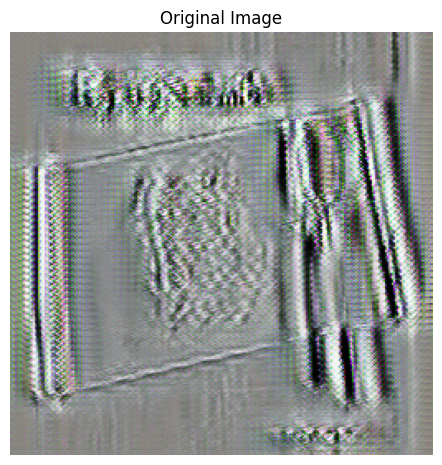

In [24]:
import torch
from torchvision import transforms
from PIL import Image
from models.networks import ResnetGenerator, get_norm_layer
# Assuming ResnetGenerator and get_norm_layer are imported from networks.py
# For example:
# from networks import ResnetGenerator, get_norm_layer

def load_pretrained_model(model_path, input_nc, output_nc, ngf=64, norm='instance', n_blocks=9, use_dropout=False, gpu_ids=[]):
    norm_layer = get_norm_layer(norm_type=norm)
    model = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=n_blocks, gpu_ids=gpu_ids, use_parallel=True, learn_residual=False)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def deblur_image(image_path, model):
    img = Image.open(image_path).convert('RGB')
    # Adjust the transform if needed
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match the model's training regime
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalization used during the model training
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    with torch.no_grad():
        output_tensor = model(img_tensor)

    output_tensor = (output_tensor + 1) / 2  # Convert output range from [-1,1] to [0,1]
    output_image = transforms.ToPILImage()(output_tensor.squeeze(0))  # Remove batch dimension and convert to image

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(output_image)
    plt.title('Original Image')
    plt.axis('off')

# Assuming you have the correct path to the pre-trained model and an image to deblur
model_path = '/content/DeblurGAN/checkpoints/experiment_name/latest_net_G.pth'
input_nc = 3  # number of input channels (e.g., RGB)
output_nc = 3  # number of output channels (should match input)
ngf = 64  # number of generator filters in the first conv layer
n_blocks = 9  # number of ResNet blocks
norm = 'instance'  # type of normalization layer
use_dropout = False  # whether to use dropout layers

model = load_pretrained_model(model_path, input_nc, output_nc, ngf, norm, n_blocks, use_dropout)
deblur_image('/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg', model)


In [25]:
x = '/content/DeblurGAN/checkpoints/experiment_name/latest_net_G.pth'
y = '/content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/1.jpeg'

<ipython-input-24-f4a40e2befc9>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


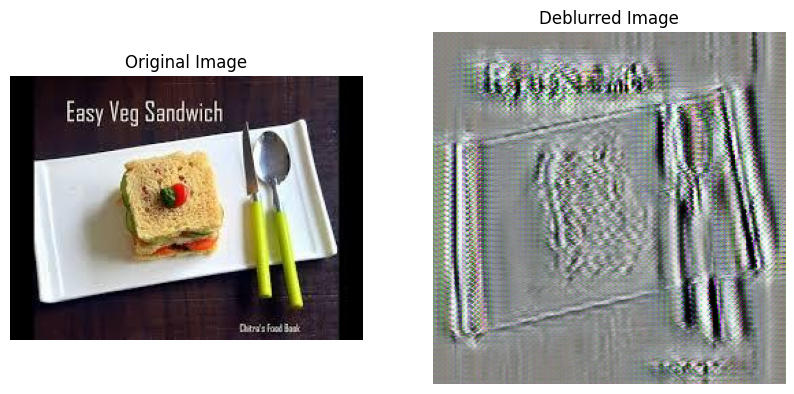

In [26]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from models.networks import ResnetGenerator, get_norm_layer

# Adjust this to correctly import your model and its norm layer
# from networks import ResnetGenerator, get_norm_layer

def deblur_image(image_path, model):
    img = Image.open(image_path).convert('RGB')

    # Display the original image with correct color mapping
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Transform and model prediction
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # This should match the model's expected input
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output_tensor = model(img_tensor)
    output_tensor = (output_tensor + 1) / 2  # Scale output to [0, 1]

    # Convert tensor to image
    output_image = transforms.ToPILImage()(output_tensor.squeeze(0))
    output_image = np.array(output_image)

    # Display the deblurred image
    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title('Deblurred Image')
    plt.axis('off')

    plt.show()

# Load your model and deblur the image
model = load_pretrained_model(x, 3, 3, 64, 'instance', 9, False)
deblur_image(y, model)


In [30]:
!pip install ssim

  Preparing metadata (setup.py) ... done
  Created wheel for ssim: filename=ssim-0.3.0-py3-none-any.whl size=9690 sha256=cdd06b81f19937209482917c848b66585efa03d9547eb1ba477d3a43092d008c
  Stored in directory: /root/.cache/pip/wheels/56/1c/d8/42fa06d55d8ab39b6d52529c7d8d055e614371de56f7dc6bc3
Successfully built ssim


In [32]:
!python test.py --dataroot x --model test --dataset_mode single --learn_residual

Traceback (most recent call last):
  File "/content/DeblurGAN/test.py", line 13, in <module>
    opt = TestOptions().parse()
  File "/content/DeblurGAN/options/base_options.py", line 61, in parse
    torch.cuda.set_device(self.opt.gpu_ids[0])
  File "/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py", line 478, in set_device
    torch._C._cuda_setDevice(device)
  File "/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py", line 319, in _lazy_init
    torch._C._cuda_init()
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx


In [ ]:
import os
import cv2
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm  # For progress bar
from sklearn.model_selection import train_test_split  # For splitting

def apply_poisson_noise(image, intensity_factor=50):
    """
    Apply Poisson noise to an image with adjustable intensity.
    Args:
        image: Input image as a NumPy array.
        intensity_factor: Factor to adjust the noise intensity.
    Returns:
        Noisy image as a NumPy array.
    """
    image = image.astype(np.float32)  # Ensure the image is in float32 format
    noisy_image = np.random.poisson(image * intensity_factor) / intensity_factor
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)  # Clip to valid range
    return noisy_image

def process_image(args):
    """
    Process a single image by adding Poisson noise and saving it.
    Args:
        args: A tuple containing image_path, output_path, and intensity_factor.
    """
    image_path, output_path, intensity_factor = args
    try:
        image = cv2.imread(image_path)
        if image is not None:
            noisy_image = apply_poisson_noise(image, intensity_factor)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, noisy_image)
            return f"Saved: {output_path}"
        else:
            return f"Failed to read image: {image_path}"
    except Exception as e:
        return f"Error processing {image_path}: {e}"

def process_dataset_with_split(input_folder, output_folder, intensity_factor=50, test_size=0.2):
    """
    Process the dataset by adding Poisson noise, splitting into training and testing sets,
    and saving them in separate folders.
    Args:
        input_folder: Path to the original dataset folder.
        output_folder: Path to save the processed dataset.
        intensity_factor: Factor to adjust the noise intensity.
        test_size: Proportion of the dataset to include in the test split (e.g., 0.2 for 20%).
    """
    train_tasks = []
    test_tasks = []

    for class_name in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_name)
        if os.path.isdir(class_path):
            image_paths = [
                os.path.join(class_path, image_name)
                for image_name in os.listdir(class_path)
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]

            # Split into training and testing sets
            train_images, test_images = train_test_split(image_paths, test_size=test_size, random_state=42)

            # Add tasks for training images
            for train_image_path in train_images:
                train_output_path = os.path.join(output_folder, "training", class_name, os.path.basename(train_image_path))
                train_tasks.append((train_image_path, train_output_path, intensity_factor))

            # Add tasks for testing images
            for test_image_path in test_images:
                test_output_path = os.path.join(output_folder, "testing", class_name, os.path.basename(test_image_path))
                test_tasks.append((test_image_path, test_output_path, intensity_factor))

    print(f"Total training images to process: {len(train_tasks)}")
    print(f"Total testing images to process: {len(test_tasks)}")

    # Process training images
    with Pool(processes=cpu_count()) as pool:
        print("Processing training images...")
        for result in tqdm(pool.imap_unordered(process_image, train_tasks), total=len(train_tasks)):
            print(result)

    # Process testing images
    with Pool(processes=cpu_count()) as pool:
        print("Processing testing images...")
        for result in tqdm(pool.imap_unordered(process_image, test_tasks), total=len(test_tasks)):
            print(result)

if __name__ == "__main__":
    base_dir = "/content/drive/MyDrive/Food Image Datasets/North Indian/North Indian 30 classes unfiltered"  # Path to original dataset
    output_dir = "/content/drive/MyDrive/Food Image Datasets/North Indian/poisson_final_split"  # Path to save noisy dataset

    # Adjust the intensity factor to increase or decrease noise
    intensity_factor = 50  # Increase for more noticeable noise

    # Process the dataset with an 80-20 train-test split
    process_dataset_with_split(base_dir, output_dir, intensity_factor, test_size=0.2)
